In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import random
from math import pi
import scipy.optimize as opt;
# Qiskit modules
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, IBMQ
from qiskit import execute
import qiskit.tools.visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.quantum_info import state_fidelity
from multiprocessing import Process, Manager,Lock

In [14]:
# Plot results
def graphic(PN,iterations,dec_times,P,N,E1,E2,init,coupling_values,precision,shots):
    x=[]
    y1=[]
    y2=[]
    p1=0
    p2=0
    for cycles in range(0,iterations):
        if __name__ == '__main__':
            manager=Manager()
            my_l = Lock()
            processes=[]
            V = manager.dict()
            V['0']=0
            V['1']=0
            for i in range(0,P):
                p = Process(target = execute_N,args=(my_l,V,N,E1,E2,dec_times,cycles,init,coupling_values,precision,shots))
                processes.append(p)
            for u in processes:
                u.start()
            for u in processes:
                u.join()
        # Print the results
            p1+=V['0']/PN
            p2+=V['1']/PN
        x.append(dec_times[0]*cycles)
        y1.append(p1)
        y2.append(p2)
        p1=0
        p2=0
    #Plot
        
    la = plt.scatter(x,y1,c='b',marker="^",label='Simulation - P(0)')
    lb = plt.scatter(x,y2,c='r',label='Simulation - P(1)')
    #p1=plt.plot(x,y1,'b--')
    #p2=plt.plot(x,y2,'r--')
    ll = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    lx = plt.xlabel('Time (ps)')
    ly = plt.ylabel('Probability')
    xx = plt.xlim(0,cycles*dec_times[0])
    plt.show()
    
    
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=1000)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

In [15]:
def u(fret,exc):
    fret.ry(-2*2.934,exc[0])

# Temporal Evolution Diagonal Hamiltonian
def hamiltonian_evolution(fret,exc,out,phase_step,E1,E2):
    ## 0
    fret.barrier()
    fret.x(exc[0])
    fret.crz(-2*E1*phase_step,exc[0],out[0])
    fret.x(exc[0])
    ## 1
    fret.barrier()
    fret.crz(-2*E2*phase_step,exc[0],out[0])
    
def u_transconj(fret,exc):  #the transconjugate of the decomposition (U) - 
                                #reverse implemention order and conjugate every matrix
    fret.ry(2*2.934,exc[0])

In [16]:
def random_generator(cycles,precision):
    n_values = cycles*2 # *2 from the number of chromophores
    values = ''
    randl=[]
    for j in range(precision):
        for i in range(n_values):
            values += str(random.randint(0,1))
        randl.append(values)
        values=''
    #print(randl)
    return randl

def apply_single_h_random(nat,exc,out,random_values,index_random,j,dec_times,coupling_values,precision,n_mol):
    for i in range(precision):
        if((j*dec_times[0])%dec_times[i+1]==0.0):
            if(random_values[i][index_random[i]]=='0'):          #  0, apply -coupling*phase_sb_step/2
                nat.crz(-coupling_values[i]*dec_times[0],exc[0],out[0])
            elif(random_values[i][index_random[i]]=='1'):        #  1, apply +coupling*phase_sb_step/2
                nat.crz(coupling_values[i]*dec_times[0],exc[0],out[0])
            index_random[i] = index_random[i]+1
        else:
            if(n_mol==0):
                if(random_values[i][index_random[i]-2]=='0'):
                        nat.crz(-coupling_values[i]*dec_times[0],exc[0],out[0])
                elif(random_values[i][index_random[i]-2]=='1'):
                        nat.crz(coupling_values[i]*dec_times[0],exc[0],out[0])
            else:
                if(random_values[i][index_random[i]-1]=='0'):
                        nat.crz(-coupling_values[i]*dec_times[0],exc[0],out[0])
                elif(random_values[i][index_random[i]-1]=='1'):
                        nat.crz(coupling_values[i]*dec_times[0],exc[0],out[0])

    return(index_random)

def system_bath_evolution_random(nat,exc,out,i,dec_times,random_values,index_random,coupling_values,precision):
    # 0
    nat.x(exc[0])
    index_random = apply_single_h_random(nat,exc,out,random_values,index_random,i,dec_times,coupling_values,precision,0)
    nat.x(exc[0])
    nat.barrier() 
    #1
    index_random = apply_single_h_random(nat,exc,out,random_values,index_random,i,dec_times,coupling_values,precision,1)
    return(index_random)

def state_initialization_random(nat,exc,out,init): # init decides if initializes other state than 00.
    nat.x(out[0])
    if (init):
        nat.x(exc[0])
        nat.x(exc[1])

In [17]:
def one_qubit_nat_random(nat,exc,out,cr,E1,E2,dec_times,cycles,init,random_values,coupling_values,precision):
    index_random = []
    for i in range(len(coupling_values)):
        index_random.append(0)
        
    state_initialization_random(nat,exc,out,init)
    nat.barrier()
    for i in range(0,cycles):
        u(nat,exc)
        hamiltonian_evolution(nat,exc,out,dec_times[0],E1,E2)
        nat.barrier()
        u_transconj(nat,exc)
        nat.barrier()
        index_random = system_bath_evolution_random(nat,exc,out,i,dec_times,random_values,index_random,coupling_values,precision)
        nat.barrier()
    nat.measure(exc,cr)

In [18]:
def execute_N(my_l,V,N,E1,E2,dec_times,cycles,init,coupling_values,precision,shotss):
    backend_sim = Aer.get_backend('qasm_simulator')
    coupling_values_=[]
    dec_times_=[]
    
    my_l.acquire()
    shots_=shotss
    E1_=E1
    E2_=E2
    init_=init
    precision_=precision
    cycles_=cycles
    N_=N
    dec_times_.append(dec_times[0])
    for i in range(precision):
        coupling_values_.append(coupling_values[i])
        dec_times_.append(dec_times[i+1])
    my_l.release()
    
    for i in range(N_):
        exc = QuantumRegister(1) # 1 qubit for excitations
        out = QuantumRegister(1) # 1 output qubit (ancilla)
        cr = ClassicalRegister(1) # 1 classical bit for state measurement
        nat = QuantumCircuit(exc,out,cr)
        
        random_values = random_generator(cycles_,precision_)
        one_qubit_nat_random(nat,exc,out,cr,E1_,E2_,dec_times_,cycles_,init_,random_values,coupling_values_,precision_)
        job_sim = execute(nat, backend_sim, shots=shots_)
        result_sim = job_sim.result()
        result_counts = result_sim.get_counts(nat)
        my_l.acquire()
        for k in result_counts:
            V[k]+=result_counts[k]/shots_
        my_l.release()
    
def execute_alg(P,N,E1,E2,dec_times,cycles,init,coupling_values,precision,shots):
    if __name__ == '__main__':
        manager=Manager()
        my_l = Lock()
        processes=[]
        V = manager.dict()
        V['0']=0
        V['1']=0
        for i in range(0,P):
            p = Process(target = execute_N,args=(my_l,V,N,E1,E2,dec_times,cycles,init,coupling_values,precision,shots))
            processes.append(p)
        for x in processes:
            x.start()
        for x in processes:
            x.join()
        # Print the results
        print("simulation: \n\n", V)
        show_results(V)




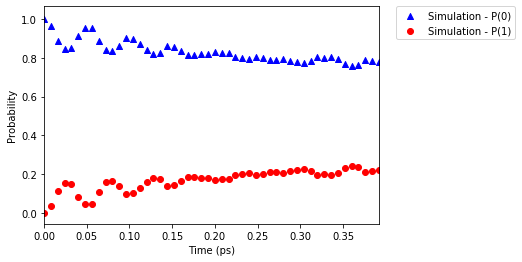

In [20]:
cycles=50  # cycles in time evolution

c=0.0299792 #speed of light, cm/ps

E1=81227.5*c #energy eigenvalue 1
E2=77108.8*c #energy eigenvalue 2

g1=300*c*2*pi  # change the number "300" to simulate different fluctuation strengths

dec_times=[0.008, 0.008]    # first index is the iteration time-step, the remaining are the fluctuator waiting times

init=False                  # initial system qubit state at 0
coupling_values=[g1]        # create more fluctuators by inserting more coupling strengths. Each coupling strength 
                            # in the index "i" corresponds to the waiting time in "dec_times" at the index "i+1"
precision=len(coupling_values)

P = 50 # number of processes
N = 5 # number of different circuits to be run in each process
PN=P*N 
shots=5000 


graphic(PN,cycles,dec_times,P,N,E1,E2,init,coupling_values,precision,shots)

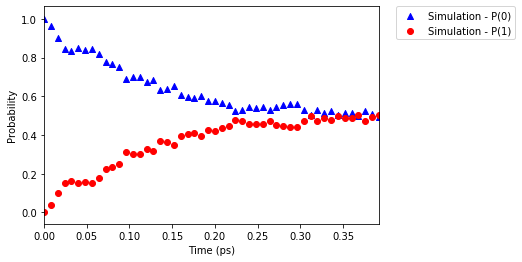

In [21]:
cycles=50  # cycles in time evolution

c=0.0299792 #cm/ps

E1=81227.5*c
E2=77108.8*c

g1=700*c*2*pi  

dec_times=[0.008, 0.008]    

init=False
coupling_values=[g1]
precision=len(coupling_values)

P = 50 
N = 5 
PN=P*N 
shots=5000

graphic(PN,cycles,dec_times,P,N,E1,E2,init,coupling_values,precision,shots)